In [36]:
import torch
from torch_geometric.data import HeteroData

# Initialize HeteroData object
data = HeteroData()

# Define node features for two types of nodes
data['user'].x = torch.tensor([
    [1, 2, 3],   # User 0 (3 features)
    [4, 5, 6]    # User 1 (3 features)
], dtype=torch.float)

data['item'].x = torch.tensor([
    [7, 8, 9, 10],     # Item 0 (4 features)
    [11, 12, 13, 14]   # Item 1 (4 features)
], dtype=torch.float)

# Define edges between users and items
data['user', 'interacts', 'item'].edge_index = torch.tensor([
    [0, 1, 0, 1],  # Source (user index)
    [0, 0, 1, 1]   # Target (item index)
], dtype=torch.long)

# Print the data object
print(data)


HeteroData(
  user={ x=[2, 3] },
  item={ x=[2, 4] },
  (user, interacts, item)={ edge_index=[2, 4] }
)


In [40]:
# Initialize HeteroData
data = HeteroData()

# Node features
data['user'].x = torch.tensor([
    [1, 2, 3],   # User 0 (3 features)
    [4, 5, 6]    # User 1 (3 features)
], dtype=torch.float)

data['item'].x = torch.tensor([
    [7, 8, 9, 10],     # Item 0 (4 features)
    [11, 12, 13, 14]   # Item 1 (4 features)
], dtype=torch.float)

# Edges (User → Item)
data['user', 'interacts', 'item'].edge_index = torch.tensor([
    [0, 1],  # User indices
    [0, 1]   # Item indices
], dtype=torch.long)

# Reverse Edges (Item → User)
data['item', 'rev_interacts', 'user'].edge_index = torch.tensor([
    [0, 1],  # Item indices
    [0, 1]   # User indices
], dtype=torch.long)

# Check data
print(data)


HeteroData(
  user={ x=[2, 3] },
  item={ x=[2, 4] },
  (user, interacts, item)={ edge_index=[2, 2] },
  (item, rev_interacts, user)={ edge_index=[2, 2] }
)


In [43]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, GCNConv
from torch_geometric.data import HeteroData

# Define the Heterogeneous GCN model
class HeteroGCN(torch.nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        # Define a HeteroConv layer with GCNConv for each relation
        self.conv1 = HeteroConv({
            ('user', 'interacts', 'item'): GCNConv(-1, hidden_dim, add_self_loops=False),
            ('item', 'rev_interacts', 'user'): GCNConv(-1, hidden_dim, add_self_loops=False)
        }, aggr="mean")

        self.conv2 = HeteroConv({
            ('user', 'interacts', 'item'): GCNConv(hidden_dim, hidden_dim, add_self_loops=False),
            ('item', 'rev_interacts', 'user'): GCNConv(hidden_dim, hidden_dim, add_self_loops=False)
        }, aggr="mean")

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}  # Apply activation
        x_dict = self.conv2(x_dict, edge_index_dict)
        return x_dict  # Return node embeddings

# Initialize model
model = HeteroGCN(hidden_dim=8)
print(model)


HeteroGCN(
  (conv1): HeteroConv(num_relations=2)
  (conv2): HeteroConv(num_relations=2)
)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    out = model(data.x_dict, data.edge_index_dict)

    # Compute loss (MSE between predicted and dummy labels)
    loss = F.mse_loss(out['user'], y_user) + F.mse_loss(out['item'], y_item)

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, SAGEConv

# Initialize HeteroData object
data = HeteroData()

# Define node features for two types of nodes
data['campaign'].x = torch.tensor([
    [1, 2, 3],   # campaign 0 (3 features)
    [1, 2, 3],   # campaign 1 (3 features)
    [1, 2, 3],   # campaign 2 (3 features)
    [1, 2, 3],   # campaign 3 (3 features)
    [1, 2, 3],   # campaign 4 (3 features)
    [1, 2, 3],   # campaign 5 (3 features)
    [1, 2, 3],   # campaign 6 (3 features)
    [4, 5, 6]    # campaign 7 (3 features)
], dtype=torch.float)

data['platform'].x = torch.tensor([
    [7, 8, 9, 10],     # platform 0 (4 features)
    [11, 12, 13, 14]   # platform 1 (4 features)
    [11, 12, 13, 14]   # platform 1 (4 features)
    [11, 12, 13, 14]   # platform 1 (4 features)
    [11, 12, 13, 14]   # platform 1 (4 features)
    [11, 12, 13, 14]   # platform 1 (4 features)
    [11, 12, 13, 14]   # platform 1 (4 features)
    [11, 12, 13, 14]   # platform 1 (4 features)
], dtype=torch.float)

# Define edges between users and items
data['campaign', 'interacts', 'platform'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # platform indices
], dtype=torch.long)

# Reverse Edges (Item → User)
data['platform', 'rev_interacts', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # platform indices
    [0, 1]   # campaign indices
], dtype=torch.long)

# Dummy labels for users and items (e.g., class labels or preference scores)
y_campaign = torch.tensor([[0.5] * 8, [1.0] * 8])  # User labels (2 users, 8D)
y_platform = torch.tensor([[1.5] * 8, [2.0] * 8])  # Item labels (2 items, 8D)

# Define the Heterogeneous GCN model
class HeteroGCN(torch.nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        # Define HeteroConv layer with SAGEConv for each relation
        self.conv1 = HeteroConv({
            ('campaign', 'interacts', 'platform'): SAGEConv(-1, hidden_dim),
            ('platform', 'rev_interacts', 'campaign'): SAGEConv(-1, hidden_dim)
        }, aggr="mean")

        self.conv2 = HeteroConv({
            ('campaign', 'interacts', 'platform'): SAGEConv(hidden_dim, hidden_dim),
            ('platform', 'rev_interacts', 'campaign'): SAGEConv(hidden_dim, hidden_dim)
        }, aggr="mean")

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}  # Apply activation
        x_dict = self.conv2(x_dict, edge_index_dict)
        return x_dict  # Return node embeddings

# Initialize model
model = HeteroGCN(hidden_dim=8)
print(model)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    out = model(data.x_dict, data.edge_index_dict)

    # Compute loss (MSE between predicted and dummy labels)
    loss = F.mse_loss(out['campaign'], y_user) + F.mse_loss(out['platform'], y_item)

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


HeteroGCN(
  (conv1): HeteroConv(num_relations=2)
  (conv2): HeteroConv(num_relations=2)
)


C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_10596\926513066.py:81: UserWarning: Using a target size (torch.Size([2, 8])) that is different to the input size (torch.Size([8, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out['user'], y_user) + F.mse_loss(out['item'], y_item)


RuntimeError: The size of tensor a (8) must match the size of tensor b (2) at non-singleton dimension 0

In [104]:
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, SAGEConv

# Initialize HeteroData object
data = HeteroData()

# Define node features for campaigns
data['campaign'].x = torch.tensor([
    [1, 2, 3],   # campaign 0 (3 features)
    [2, 2, 3],   # campaign 1 (3 features)
    [3, 2, 3],   # campaign 2 (3 features)
    [4, 2, 3],   # campaign 3 (3 features)
    [5, 2, 3],   # campaign 4 (3 features)
    [6, 2, 3],   # campaign 5 (3 features)
    [7, 2, 3],   # campaign 6 (3 features)
    [8, 5, 6]    # campaign 7 (3 features)
], dtype=torch.float)

# Define node features for platforms
data['platform'].x = torch.tensor([
    [128, 0, 0, 1],     # platform 0 (4 features)
    [16, 0, 1, 0],   # platform 1 (4 features)
    [4, 1, 0, 0],   # platform 2 (4 features)
    [4, 1, 0, 0],   # platform 3 (4 features)
    [128, 0, 0, 1],   # platform 4 (4 features)
    [4, 1, 0, 0],   # platform 5 (4 features)
    [16, 0, 1, 0],   # platform 6 (4 features)
    [128, 0, 0, 1]    # platform 7 (4 features)
], dtype=torch.float)

# Define node features for platforms
data['channel'].x = torch.tensor([
    [32, 1, 0, 0, 0, 0],     # channel 0 (4 features)
    [4, 0, 1, 0, 0, 0],   # platform 1 (4 features)
    [4, 0, 1, 0, 0, 0],   # platform 2 (4 features)
    [32, 1, 0, 0, 0, 0],   # platform 3 (4 features)
    [1, 0, 0, 1, 0, 0],   # platform 4 (4 features)
    [32, 1, 0, 0, 0, 0],   # platform 5 (4 features)
    [64, 0, 0, 0, 1, 0],   # platform 6 (4 features)
    [8, 0, 0, 0, 0, 1]    # platform 7 (4 features)
], dtype=torch.float)

data['creative'].x = torch.tensor([
    [1500, 1, 0],
    [1550, 0, 1],
    [1560, 1, 0],
    [1570, 1, 0],
    [1560, 0, 1],
    [1520, 0, 1],
    [1590, 1, 0],
    [1530, 0, 1],
], dtype=torch.float)

data['template'].x = torch.tensor([
    [90],
    [93],
    [23],
    [92],
    [89],
    [23],
    [89],
    [90],
], dtype=torch.float)

data['keywords'].x = torch.rand((8, 40), dtype=torch.float)  # 8 nodes, 40 features each

print(data['keywords'].x.shape)  # Should output: torch.Size([8, 40])


# Define edges between campaigns and platforms
data['campaign', 'hosted_on', 'platform'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # platform indices
], dtype=torch.long)

# Reverse Edges (Platform → Campaign)
data['platform', 'rev_hosted_on', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # platform indices
    [0, 1]   # campaign indices
], dtype=torch.long)

# Define edges between campaigns and channels
data['campaign', 'uses', 'channel'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)

# Reverse Edges (Platform → channel)
data['platform', 'rev_uses', 'channel'].edge_index = torch.tensor([
    [0, 1],  # platform indices
    [0, 1]   # channel indices
], dtype=torch.long)

# Reverse Edges (Creative → Campaign)
data['creative', 'uses', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # creative indices
    [0, 1]   # campaign indices
], dtype=torch.long)

# Reverse Edges (Campaign → Creative)
data['campaign', 'rev_uses', 'creative'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # creative indices
], dtype=torch.long)

# Reverse Edges (Creative → Template)
data['creative', 'designed_with', 'template'].edge_index = torch.tensor([
    [0, 1],  # creative indices
    [0, 1]   # template indices
], dtype=torch.long)

# Reverse Edges (Template → Creative)
data['template', 'rev_designed_with', 'creative'].edge_index = torch.tensor([
    [0, 1],  # template indices
    [0, 1]   # creative indices
], dtype=torch.long)

data['campaign', 'associated_with', 'keywords'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)

data['keywords', 'rev_associated_with', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)

# The corresponding click values for each record
click_values = torch.tensor([45, 32, 50, 45, 2, 65, 87, 43])  # one click value for each record
click_values = click_values.float()

# Ensure shapes are appropriate
print(f"clicks shape: {click_values.shape}")



torch.Size([8, 40])
clicks shape: torch.Size([8])


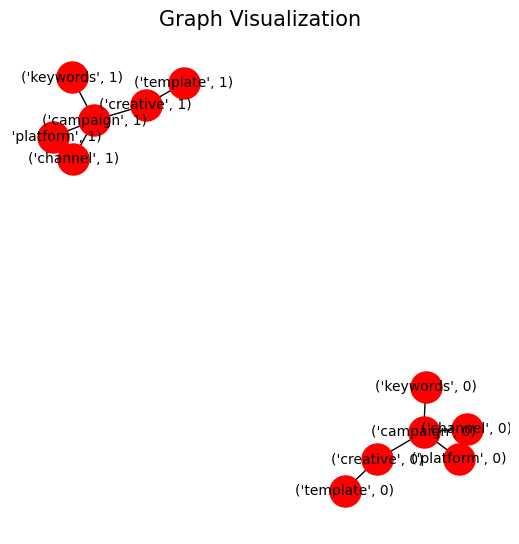

In [105]:
import matplotlib.pyplot as plt
import networkx as nx
import torch

def visualize_graph(data):
    # Create a new graph using NetworkX
    G = nx.Graph()

    # Add nodes and edges to the graph
    for edge_type, edge_index in data.edge_index_dict.items():
        src_type, _, dst_type = edge_type  # Extract source and destination node types
        for src, dst in edge_index.t().tolist():  # Add edges to the graph
            # Add nodes as (node_type, node_id)
            G.add_node((src_type, src))
            G.add_node((dst_type, dst))
            G.add_edge((src_type, src), (dst_type, dst))
    
    # Position nodes using the spring layout (force-directed layout)
    pos = nx.spring_layout(G)

    # Draw the graph
    plt.figure(figsize=(5, 5))
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='red', font_size=10)
    plt.title("Graph Visualization", fontsize=15)
    plt.show()

# Visualize the graph
visualize_graph(data)


In [ ]:
# Define the Heterogeneous GCN model
class HeteroGCN(torch.nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        # Define HeteroConv layer with SAGEConv for each relation
        self.conv1 = HeteroConv({
            ('campaign', 'hosted_on', 'platform'): SAGEConv(-1, hidden_dim),
            ('platform', 'rev_hosted_on', 'campaign'): SAGEConv(-1, hidden_dim),
            ('campaign', 'uses','channel'): SAGEConv(-1, hidden_dim),
            ('channel', 'rev_uses', 'campaign'): SAGEConv(-1, hidden_dim),
            ('creative', 'uses', 'campaign'): SAGEConv(-1, hidden_dim),
            ('campaign', 'rev_uses', 'creative'): SAGEConv(-1, hidden_dim),
            ('creative', 'designed_with','template'): SAGEConv(-1, hidden_dim),
            ('template', 'rev_designed_with','creative'): SAGEConv(-1, hidden_dim),
            ('campaign', 'associated_with', 'keywords'): SAGEConv(-1, hidden_dim),
            ('keywords', 'rev_associated_with', 'campaign'): SAGEConv(-1, hidden_dim)
        }, aggr="mean")

        self.conv2 = HeteroConv({
            ('campaign', 'hosted_on', 'platform'): SAGEConv(hidden_dim, hidden_dim),
            ('platform', 'rev_hosted_on', 'campaign'): SAGEConv(hidden_dim, hidden_dim),
            ('campaign', 'uses','channel'): SAGEConv(hidden_dim, hidden_dim),
            ('channel', 'rev_uses', 'campaign'): SAGEConv(hidden_dim, hidden_dim),
            ('creative', 'uses', 'campaign'): SAGEConv(hidden_dim, hidden_dim),
            ('campaign', 'rev_uses', 'creative'): SAGEConv(hidden_dim, hidden_dim),
            ('creative', 'designed_with','template'): SAGEConv(-1, hidden_dim),
            ('template', 'rev_designed_with','creative'): SAGEConv(-1, hidden_dim),
            ('campaign', 'associated_with', 'keywords'): SAGEConv(-1, hidden_dim),
            ('keywords', 'rev_associated_with', 'campaign'): SAGEConv(-1, hidden_dim)
        }, aggr="mean")

        # Fully connected layer to produce a single output (click value)
        self.fc = torch.nn.Linear(hidden_dim * 6, 1)  # Concatenating features from 6 node types

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}  # Apply ReLU activation
        x_dict = self.conv2(x_dict, edge_index_dict)
        
        # Concatenate the features of campaign, platform, and channel for each record
        x_combined = torch.cat([x_dict['campaign'], x_dict['platform'],
                                x_dict['channel'], x_dict['creative'], x_dict['template'], x_dict['keywords']], dim=1)
        
        # Pass through the fully connected layer to get the single click prediction
        out = self.fc(x_combined)
        
        return out

# Initialize model
model = HeteroGCN(hidden_dim=8)
print(model)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop for regression (click prediction)
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    out = model(data.x_dict, data.edge_index_dict)

    # Compute loss (MSE between predicted clicks and actual click values)
    loss = F.mse_loss(out.squeeze(), click_values)  # Ensure the shapes match

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


HeteroGCN(
  (conv1): HeteroConv(num_relations=10)
  (conv2): HeteroConv(num_relations=10)
  (fc): Linear(in_features=48, out_features=1, bias=True)
)
Epoch 0, Loss: 2955.3887
Epoch 10, Loss: 587.9915
Epoch 20, Loss: 395.4268
Epoch 30, Loss: 270.9300
Epoch 40, Loss: 193.8430
Epoch 50, Loss: 159.3347
Epoch 60, Loss: 134.7139
Epoch 70, Loss: 116.2605
Epoch 80, Loss: 101.7130
Epoch 90, Loss: 84.8846


In [108]:
# Evaluation function
def evaluate_model(model, data, click_values, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation during evaluation
        # Forward pass
        out = model(data.x_dict, data.edge_index_dict)
        
        # Compute MSE loss between predictions and actual click values
        mse = F.mse_loss(out.squeeze(), click_values)  # Ensure the shapes match
        
        return mse.item()
    
# Evaluate the model on the same dataset or a separate test set
mse_score = evaluate_model(model, data, click_values)
print(f"Test MSE: {mse_score:.4f}")

Test MSE: 65.9552


In [109]:
def r_squared(y_true, y_pred):
    ss_tot = ((y_true - y_true.mean()) ** 2).sum()
    ss_res = ((y_true - y_pred) ** 2).sum()
    return 1 - (ss_res / ss_tot)

# Get predictions
predictions = model(data.x_dict, data.edge_index_dict).squeeze()

# Calculate R² score
r2_score = r_squared(click_values, predictions)
print(f"Test R²: {r2_score:.4f}")


Test R²: 0.8744
